# Spark Collaborative Filtering Deep Dive
**Spark MLlib**은 행렬 분해 모델을 훈련하는 데 사용될 수 있는 collaborative filtering 알고리즘을 제공한다. 추천하는 아이템에 대한 유저의 explicit 혹은 implicit 평점을 예측한다.

## 1. Matrix factorization algorithm

## 3. Spark ALS based Movielens recommender

In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator
from pyspark.sql.types import StructType, StructField, FloatType, IntegerType, LongType

from recommenders.datasets import movielens
from recommenders.utils.spark_utils import start_or_get_spark
from recommenders.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from recommenders.tuning.parameter_sweep import generate_param_grid
from recommenders.datasets.spark_splitters import spark_random_split

In [2]:
schema = StructType((StructField('UserId', IntegerType()),
                    StructField('ItemId', IntegerType()),
                    StructField('Rating', FloatType()),
                    StructField('Timestamp', LongType()),
                    ))

In [3]:
spark = start_or_get_spark('ALS Deep Dive', memory='16g')
spark.conf.set('spark.sql.analyzer.failAmbiguousSelfJoin', 'false')

22/07/18 15:30:27 WARN Utils: Your hostname, qwer-ND resolves to a loopback address: 127.0.1.1; using 10.140.50.75 instead (on interface enp3s0)
22/07/18 15:30:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/07/18 15:30:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Load and prepare data
dfs = movielens.load_spark_df(spark=spark, size='100k', schema=schema)
dfs.show(5)

100%|█████████████████████████████████████| 4.81k/4.81k [00:02<00:00, 2.01kKB/s]


+------+------+------+---------+
|UserId|ItemId|Rating|Timestamp|
+------+------+------+---------+
|   196|   242|   3.0|881250949|
|   186|   302|   3.0|891717742|
|    22|   377|   1.0|878887116|
|   244|    51|   2.0|880606923|
|   166|   346|   1.0|886397596|
+------+------+------+---------+
only showing top 5 rows



In [6]:
dfs_train, dfs_test = spark_random_split(dfs, ratio=0.8, seed=42)

In [8]:
# Train a movielens model
# Spark ALS는 테스트셋에서 더 견고한 검증을 위해 콜드유저를 드랍할 수 있다.
als = ALS(maxIter=15, rank=10, regParam=0.05,
         userCol='UserId', itemCol='ItemId', ratingCol='Rating', coldStartStrategy='drop')

model = als.fit(dfs_train)

22/07/18 15:41:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/07/18 15:41:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/07/18 15:41:00 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [12]:
# Prediction
dfs_pred = model.transform(dfs_test).drop('Rating')

evaluations = SparkRatingEvaluation(dfs_test, dfs_pred,
                                   col_user='UserId', col_item='ItemId',
                                   col_rating='Rating', col_prediction='prediction')

print("RMSE score = {}".format(evaluations.rmse()),
    "MAE score = {}".format(evaluations.mae()),
    "R2 score = {}".format(evaluations.rsquared()),
    "Explained variance score = {}".format(evaluations.exp_var()),
    sep="\n")

RMSE score = 0.9556153718189598
MAE score = 0.7450058612644982
R2 score = 0.281035394886475
Explained variance score = 0.28637299500649005


In [13]:
# 랭킹 메트릭은 보통 아이템의 리스트를 추천하는 시나리오에 적용한다.
# Get the cross join of all user-item pairs and score them
users = dfs_train.select('UserId').distinct()
items = dfs_train.select('ItemId').distinct()
user_item = users.crossJoin(items)
dfs_pred = model.transform(user_item)

# Remove seen items
dfs_pred_unseen = dfs_pred.alias('pred').join(
dfs_train.alias('train'), (dfs_pred['UserId']==dfs_train['UserId'])&(dfs_pred['ItemId']==dfs_train['ItemId']), how='outer')

dfs_pred_final = dfs_pred_unseen.filter(dfs_pred_unseen['train.Rating'].isNull()).select(
'pred.'+'UserId', 'pred.'+'ItemId', 'pred.'+'prediction')

dfs_pred_final.show()

22/07/18 15:53:39 WARN Column: Constructing trivially true equals predicate, 'UserId#0 = UserId#0'. Perhaps you need to use aliases.


+------+------+----------+
|UserId|ItemId|prediction|
+------+------+----------+
|     1|    46| 3.1508272|
|     1|   255|  2.860598|
|     1|   284| 2.8368096|
|     1|   285|  5.170787|
|     1|   318| 4.2681656|
|     1|   329|  3.229271|
|     1|   335| 3.5721858|
|     1|   353| 2.8815293|
|     1|   371|  2.223076|
|     1|   372| 3.8601854|
|     1|   381| 3.7922728|
|     1|   391| 2.5018885|
|     1|   409| 2.6668408|
|     1|   413| 2.5902538|
|     1|   417| 2.7754765|
|     1|   440|0.44709682|
|     1|   449| 3.3577588|
|     1|   463|  4.178662|
|     1|   480|  4.390193|
|     1|   488| 3.7448568|
+------+------+----------+
only showing top 20 rows



In [14]:
evaluations = SparkRankingEvaluation(dfs_test, dfs_pred_final,
                                    col_user='UserId', col_item='ItemId',
                                    col_rating='Rating', col_prediction='prediction',
                                    k='10')

print(
    "Precision@k = {}".format(evaluations.precision_at_k()),
    "Recall@k = {}".format(evaluations.recall_at_k()),
    "NDCG@k = {}".format(evaluations.ndcg_at_k()),
    "Mean average precision = {}".format(evaluations.map_at_k()),
    sep="\n"
)

Precision@k = 0.036797454931071054
Recall@k = 0.01674812385258983
NDCG@k = 0.03464532196785911
Mean average precision = 0.0044582184851539855


RMSE score : [1.0936706676579813, 0.9157571929292366, 1.0612967403988198, 1.3667937388998799, 1.2821808392058507, 0.9198704675120541, 1.0608155367018652, 1.3667943623266332, 1.4180620800371282, 0.9208848234571148, 1.0610791154853205, 1.3667940931392257, 1.50164660094278, 0.9222090879745083, 1.0610830731032301, 1.366794119660382]
RMSE score : [1.0937, 0.9158, 1.0613, 1.3668, 1.2822, 0.9199, 1.0608, 1.3668, 1.4181, 0.9209, 1.0611, 1.3668, 1.5016, 0.9222, 1.0611, 1.3668]


<AxesSubplot:xlabel='reg. Parameter', ylabel='rank'>

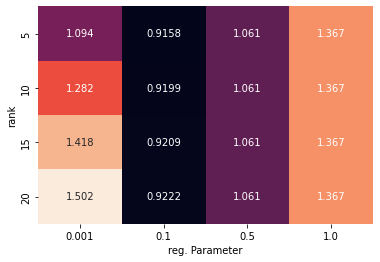

In [17]:
# Fine tune the model
# Spark ALS 모델의 예측 성능은 파라미터의 영향을 받는다.
# `rank`(number of latent factors)가 클수록 많은 고유 성분을 고려하고, `maxIters`가 클수록 optimal point에 잘 수렴하고, `regParam`은 오버피팅을 피하기 위해 실증적으로 선택된다
param_dict = {'rank':[5, 10, 15, 20], 'regParam':[0.001, 0.1, 0.5, 1.0]}
param_grid = generate_param_grid(param_dict)

rmse_score = []

for g in param_grid:
    als = ALS(userCol='UserId', itemCol='ItemId', ratingCol='Rating',
             coldStartStrategy='drop', **g)
    
    model = als.fit(dfs_train)
    dfs_pred = model.transform(dfs_test).drop('Rating')
    evaluations = SparkRatingEvaluation(dfs_test, dfs_pred,
                                       col_user='UserId', col_item='ItemId',
                                       col_rating='Rating', col_prediction='prediction')
    
    rmse_score.append(evaluations.rmse())

print('RMSE score :', rmse_score)
rmse_score = [float('%.4f'%x) for x in rmse_score]
print('RMSE score :', rmse_score)
rmse_score_array = np.reshape(rmse_score, (len(param_dict['rank']),
                                           len(param_dict['regParam'])))

rmse_df = pd.DataFrame(data=rmse_score_array, index=pd.Index(param_dict['rank'], name='rank'),
                      columns=pd.Index(param_dict['regParam'], name='reg. Parameter'))

fig, ax = plt.subplots()
sns.heatmap(rmse_df, cbar=False, annot=True, fmt='.4g')

In [18]:
# Top-k recommentaion
dfs_rec = model.recommendForAllUsers(10)
dfs_rec.show()

+------+--------------------+
|UserId|     recommendations|
+------+--------------------+
|     1|[{1536, 3.8742242...|
|     3|[{1536, 3.085722}...|
|     6|[{1536, 3.709466}...|
|    12|[{1536, 4.497266}...|
|    13|[{1536, 3.4071114...|
|    16|[{1536, 4.5356517...|
|    20|[{1536, 3.3076372...|
|    22|[{1536, 3.6966453...|
|    26|[{1536, 3.1780167...|
|    27|[{1536, 3.4307716...|
|    28|[{1536, 3.948202}...|
|    31|[{1536, 3.9266136...|
|    34|[{1536, 4.550511}...|
|    40|[{1536, 2.8940613...|
|    44|[{1536, 3.8168476...|
|    47|[{1536, 4.067054}...|
|    48|[{1536, 3.8780575...|
|    52|[{1536, 4.332321}...|
|    53|[{1536, 4.0254474...|
|    54|[{1536, 3.9313898...|
+------+--------------------+
only showing top 20 rows



In [19]:
users = dfs_train.select(als.getUserCol()).distinct().limit(5)
dfs_rec_sub = model.recommendForUserSubset(users, 10)
dfs_rec_sub.show()

+------+--------------------+
|UserId|     recommendations|
+------+--------------------+
|   471|[{1536, 3.263928}...|
|   463|[{1536, 3.1270876...|
|   833|[{1536, 3.2608852...|
|   496|[{1536, 3.258398}...|
|   148|[{1536, 3.8723602...|
+------+--------------------+



In [20]:
spark.stop()

일반적으로 모든 유저에 대한 top-k 추천을 계산하는 것은 ASL 기반 추천 시스템의 파이프라인에서 병목현상을 일으킨다. 계산 비용이 큰 cross join을 수행해야 하고, user-item 쌍의 내적이 개별적으로 계산된다. 연산을 가속시켜주는 특정 라이브러리에서 가능한 행렬 블록곱셈을 활용하는 대신에.